In [1]:
import scipy as sp
import numpy as np
from pylab import *
import seaborn as sns
import joblib
%config InlineBackend.figure_format='retina'

In [2]:
def sim_trigger(t_fiber = 2.1,t_scint = 5.2,threshold_list = [0,1,2],signal_npe = 6,N_sample= 10_000):
    """
    Return: 
        trigger_time: with dimesion of (N_sample, len(threshold))
    """
    t_sample_fiber = np.random.exponential(t_fiber, (N_sample,signal_npe))
    t_sample_scint = np.random.exponential(t_scint, (N_sample,signal_npe))
    t_sample = np.sort(t_sample_fiber+t_sample_scint, axis=1)

    trigger_time = t_sample[:,threshold_list] 
    return trigger_time

def process_dt(trigger_time):
    """
    Return: 
        dt_width: equivalent sigma of single channel, 1-D list with length of (len(threshold))
    """    
    t = trigger_time
    dt = (t[:len(t)//2]- t[len(t)//2:])/np.sqrt(2)
    # Use the width of middle 76% quantile to estimate the sigma
    dt_width = np.diff(np.quantile(dt, [0.115, 1-0.115], axis=0), axis=0)/(2*np.sqrt(2*np.log(2)))
    
    return dt_width



# Physics parameter
# t_fiber = 2.1
t_scint = 5.2

# Simulation setting
N_sample= 10_000

# Parameters to scan:
threshold_list = [0,1,2,3,4]
signal_npe_list = np.arange(5,25)
t_fiber_list   = [1.5, 2, 3, 4, 5, 6, 7, 8]

# Generate events
results_raw = np.zeros((len(signal_npe_list), len(t_fiber_list), N_sample,len(threshold_list)))
for ipe, npe in enumerate(signal_npe_list):
    for ifiber, tfiber in enumerate(t_fiber_list):
        trigger_time = sim_trigger(t_fiber = tfiber,t_scint = t_scint,threshold_list = threshold_list,signal_npe = npe,N_sample= N_sample)
        results_raw[ipe,ifiber,:,:] = trigger_time

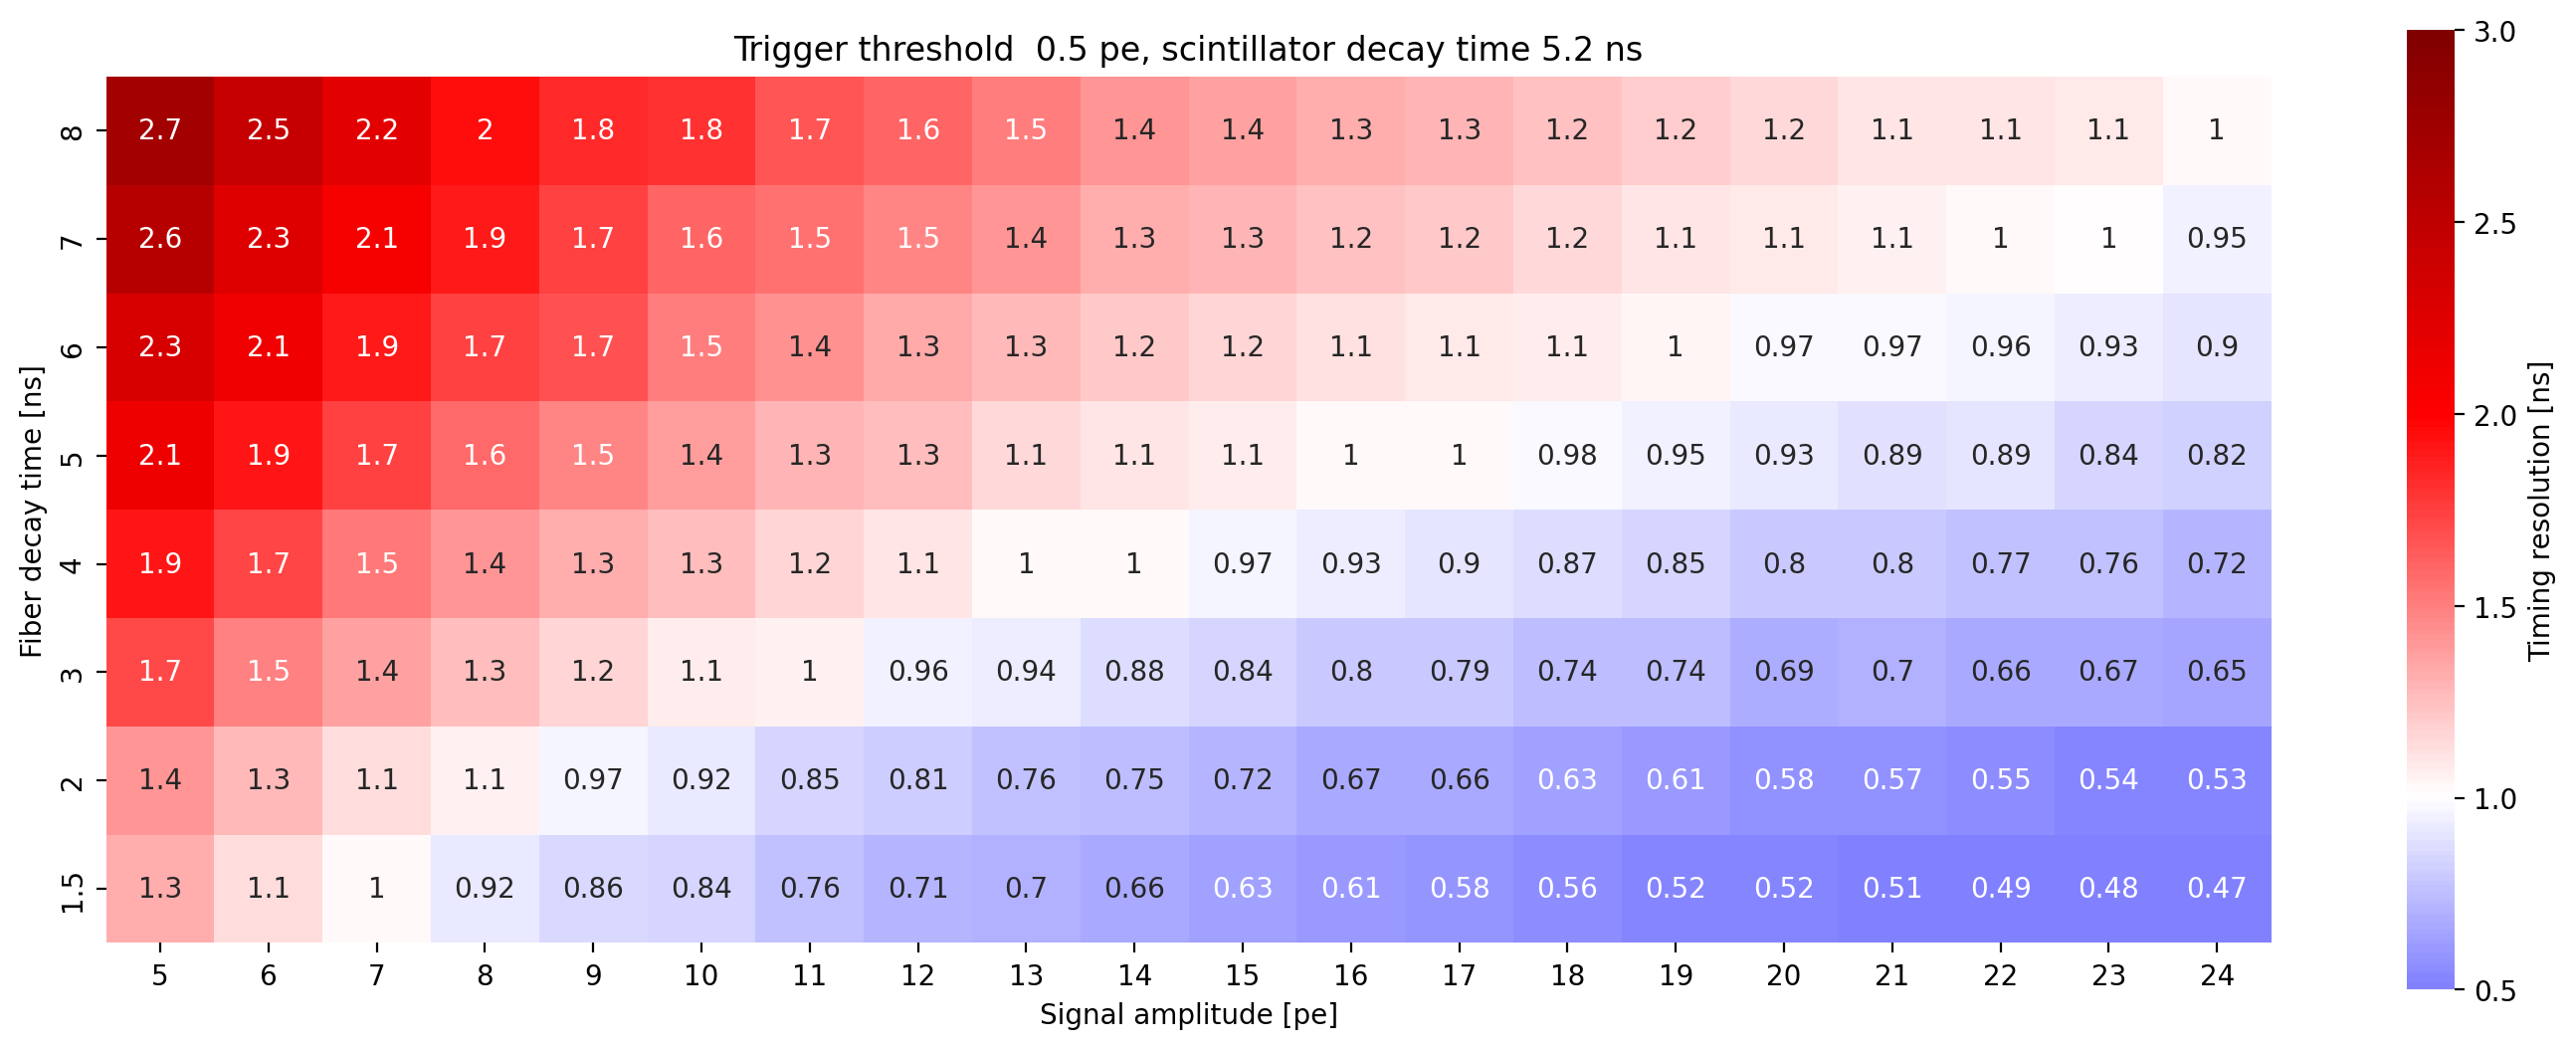

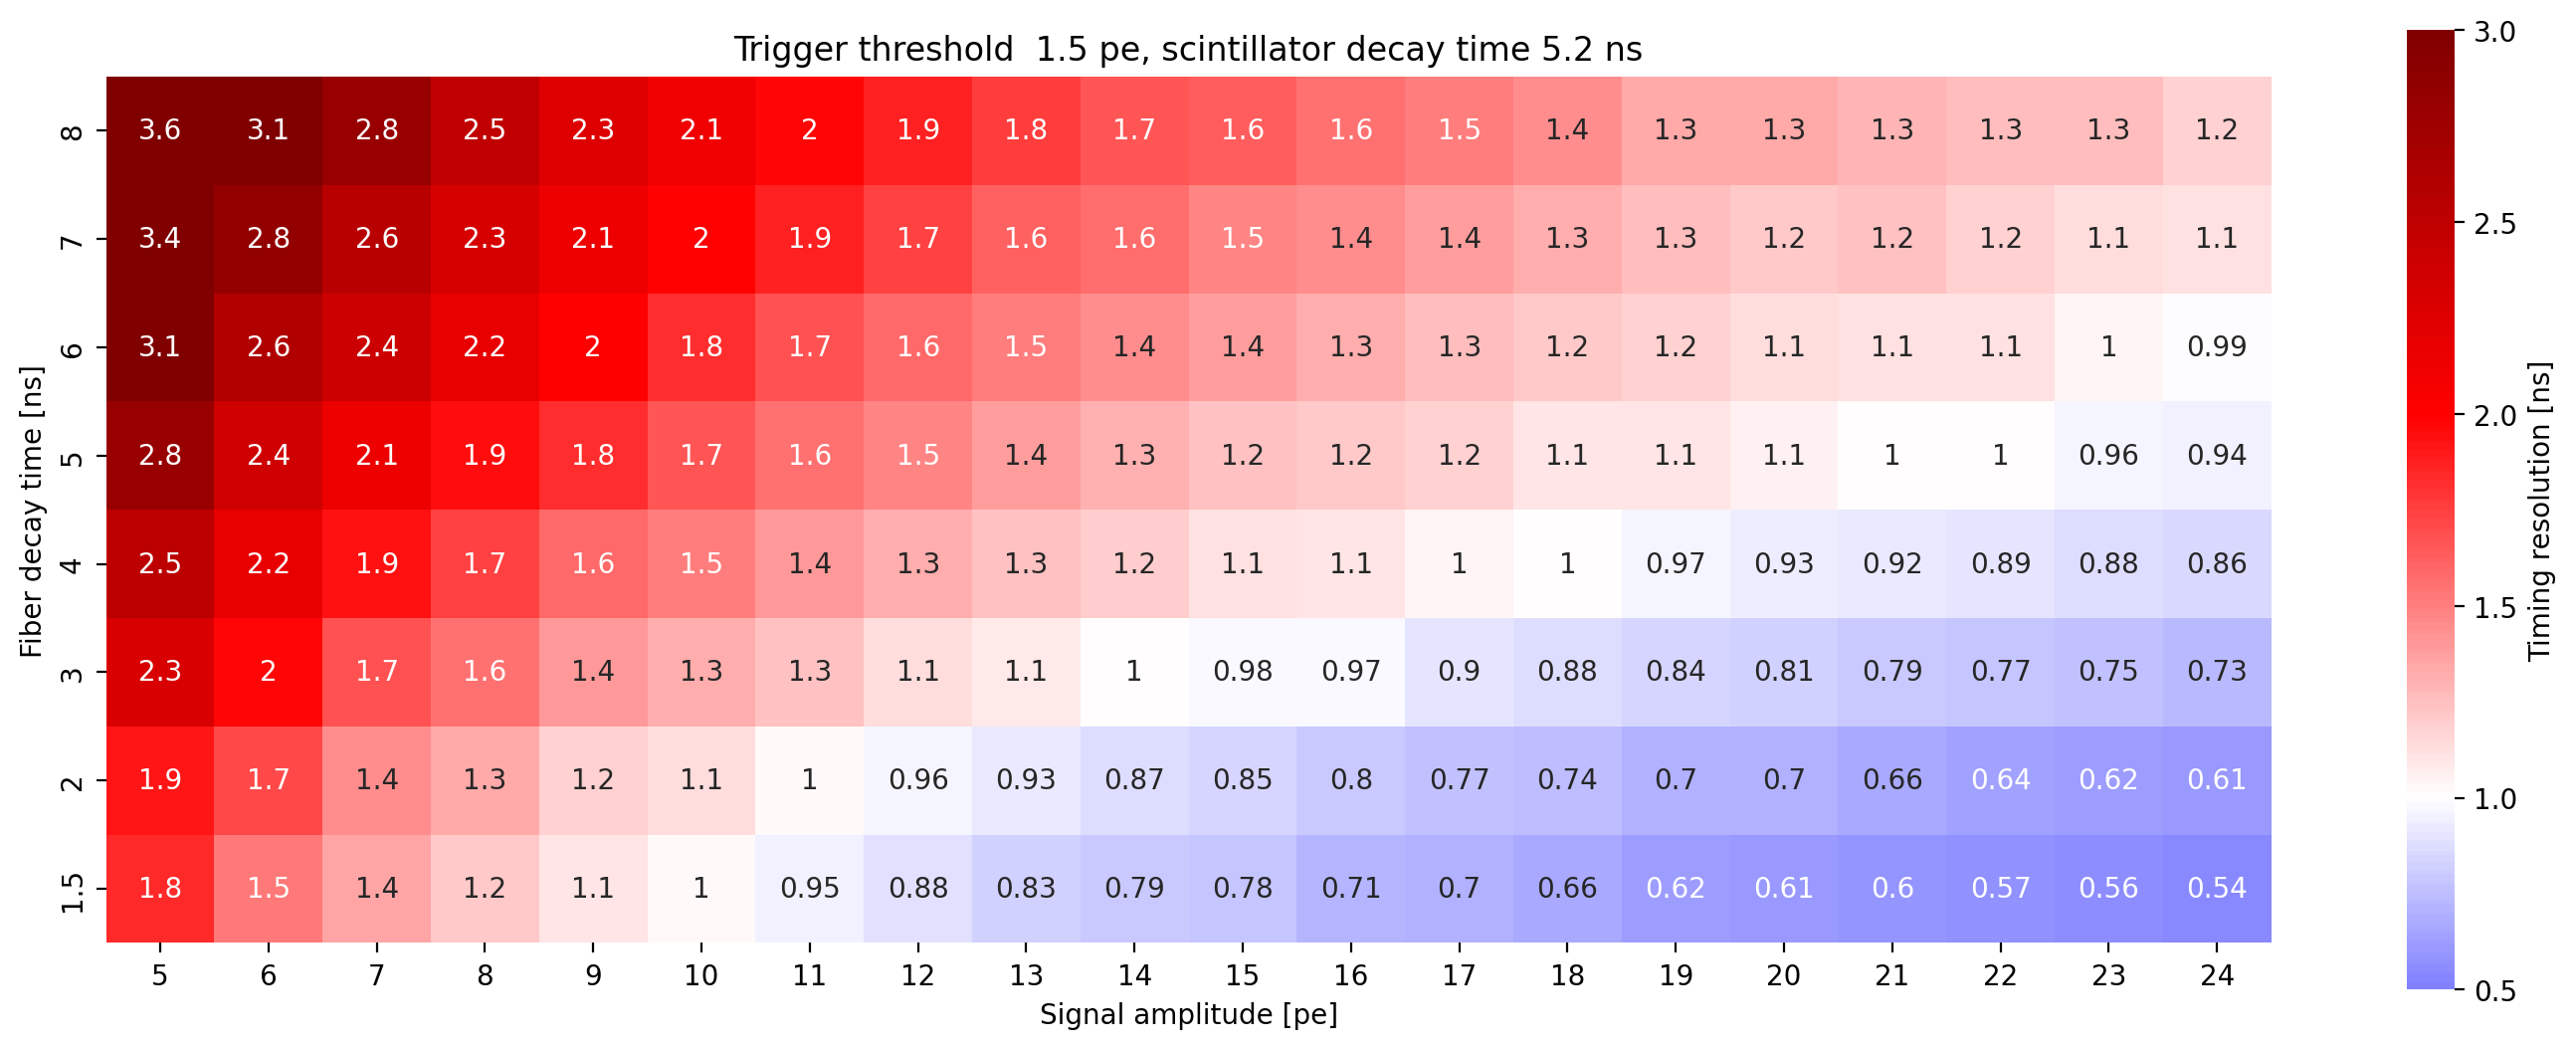

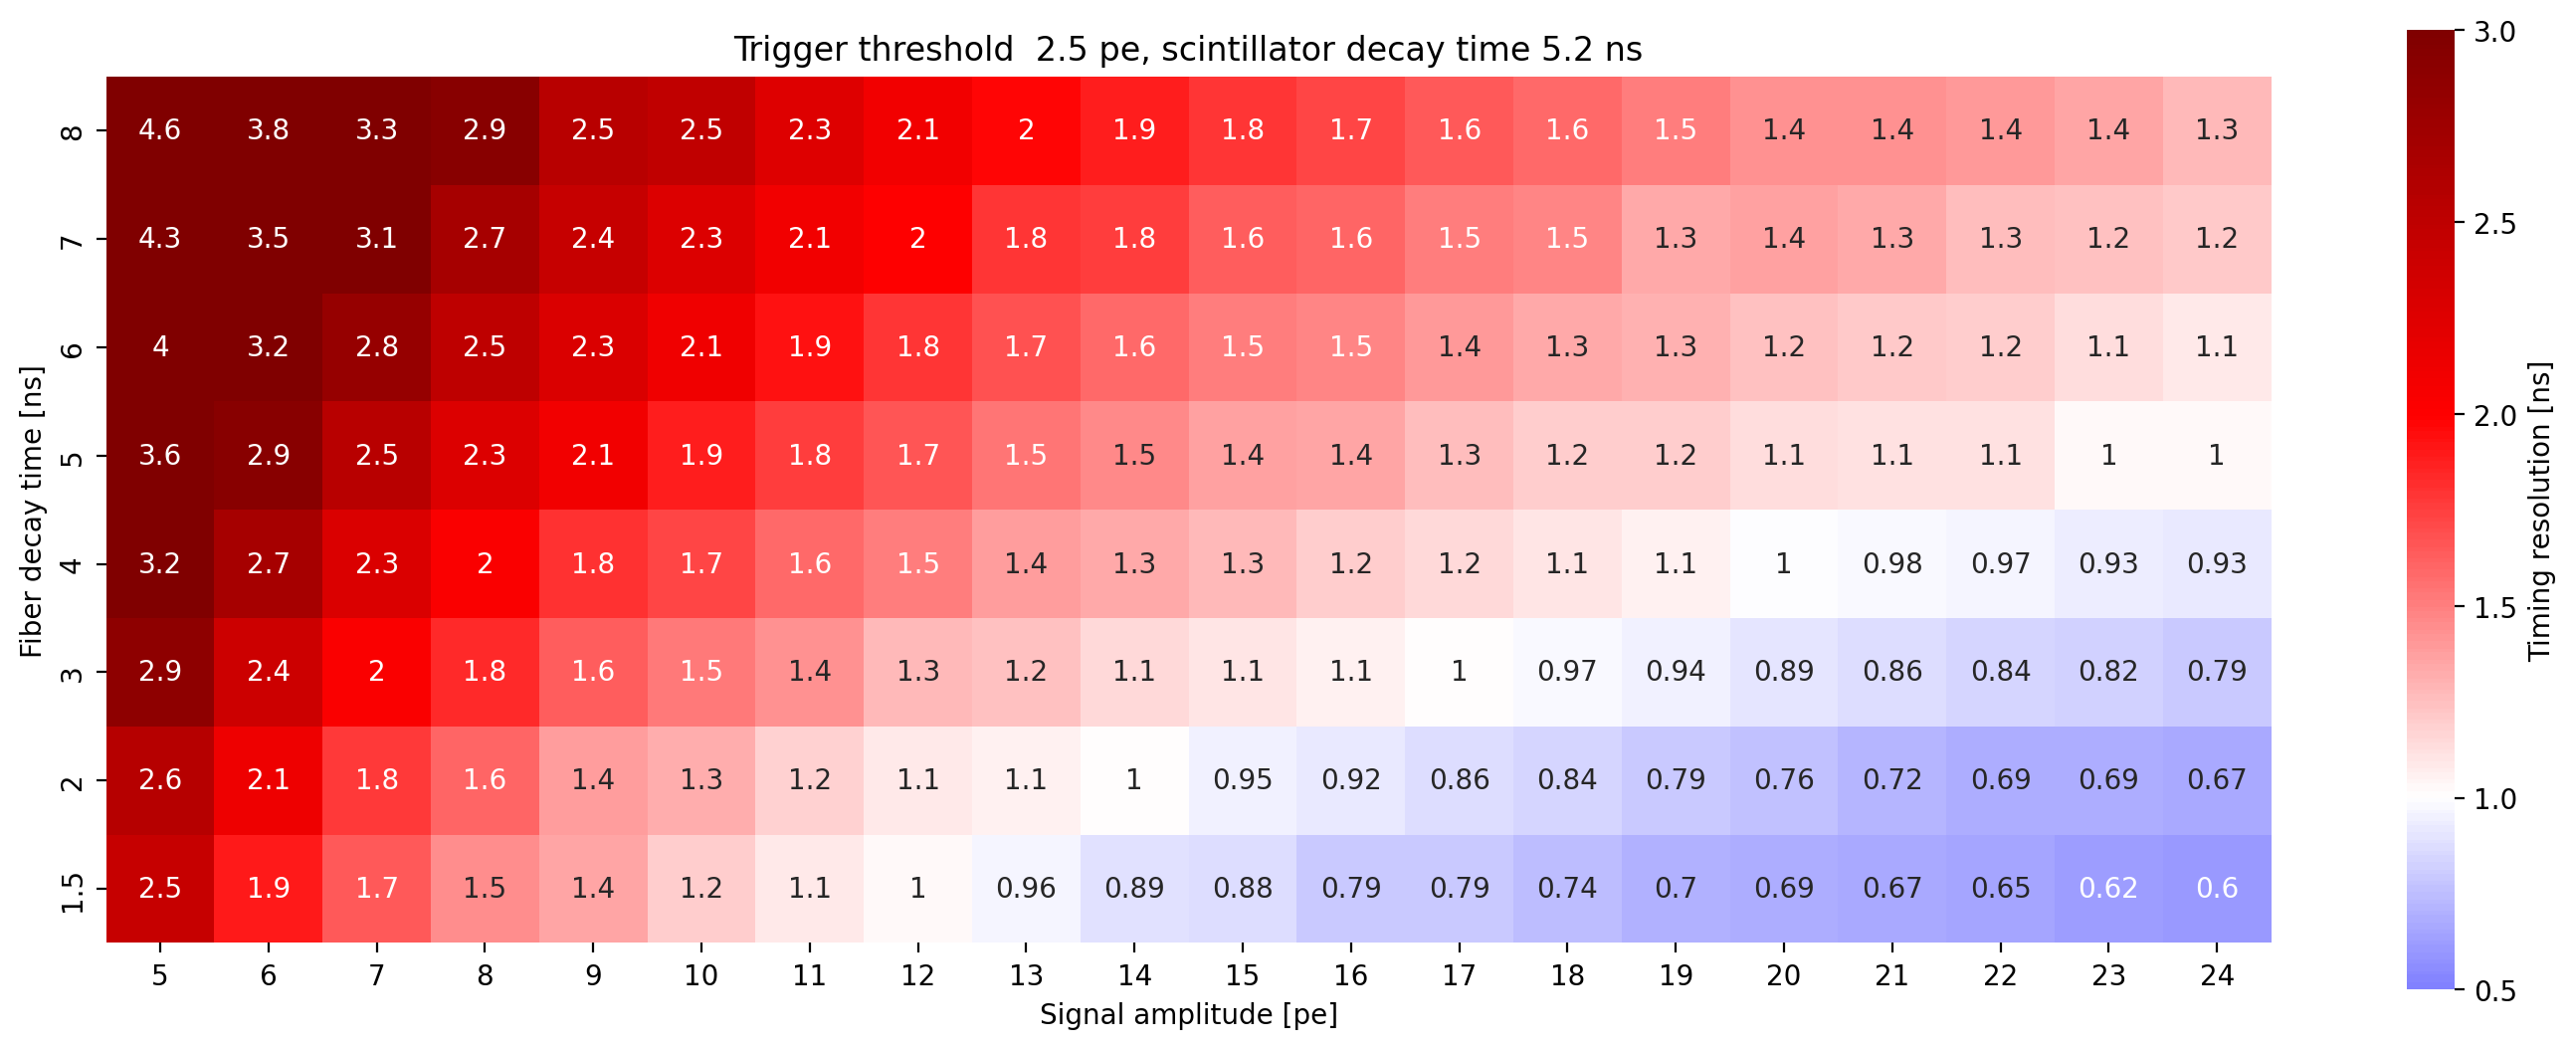

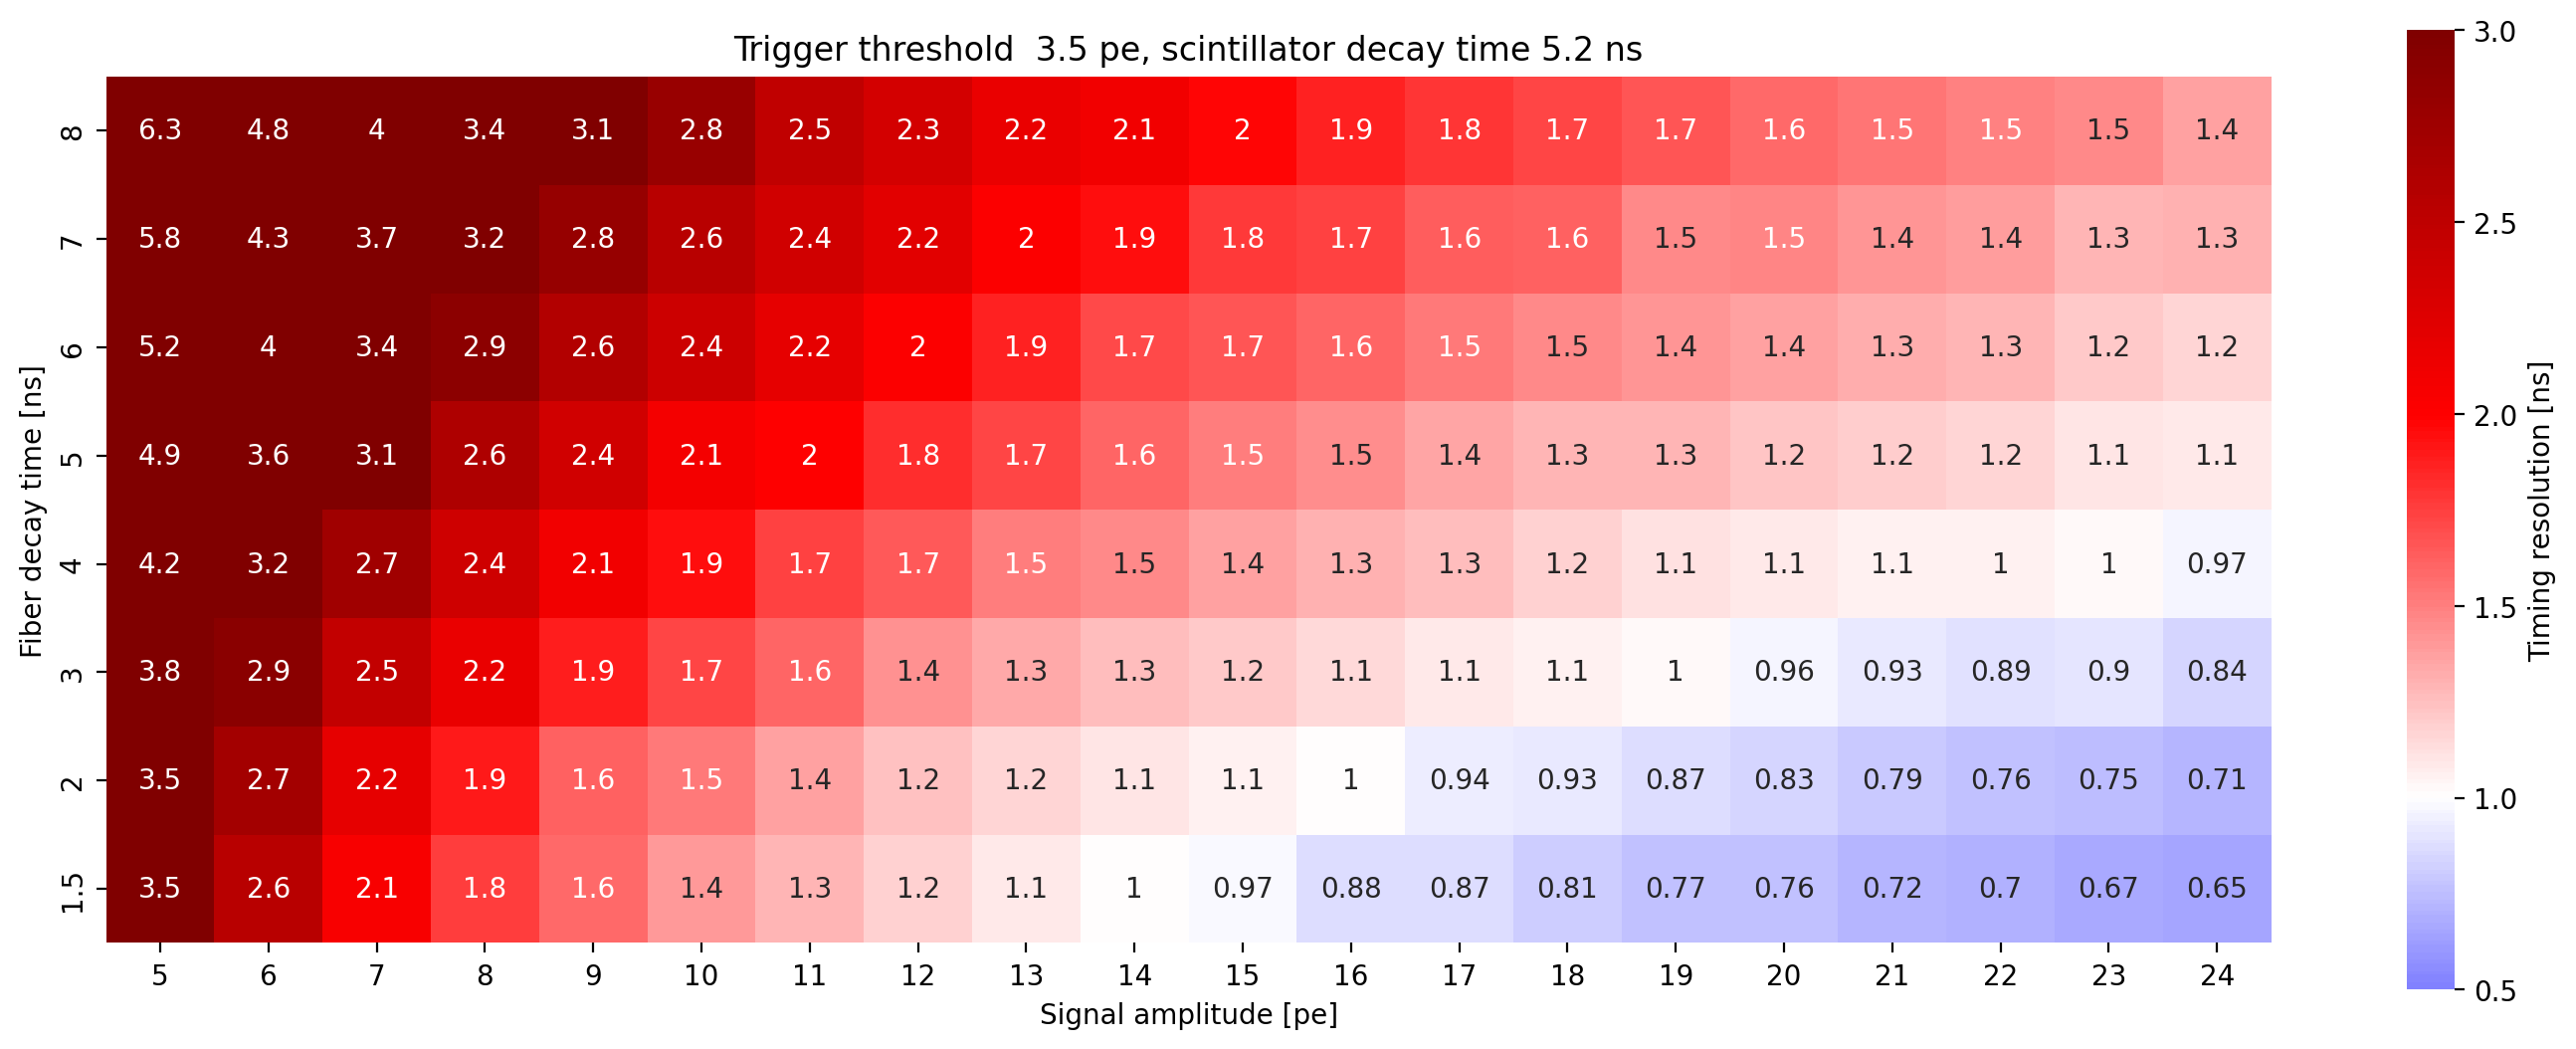

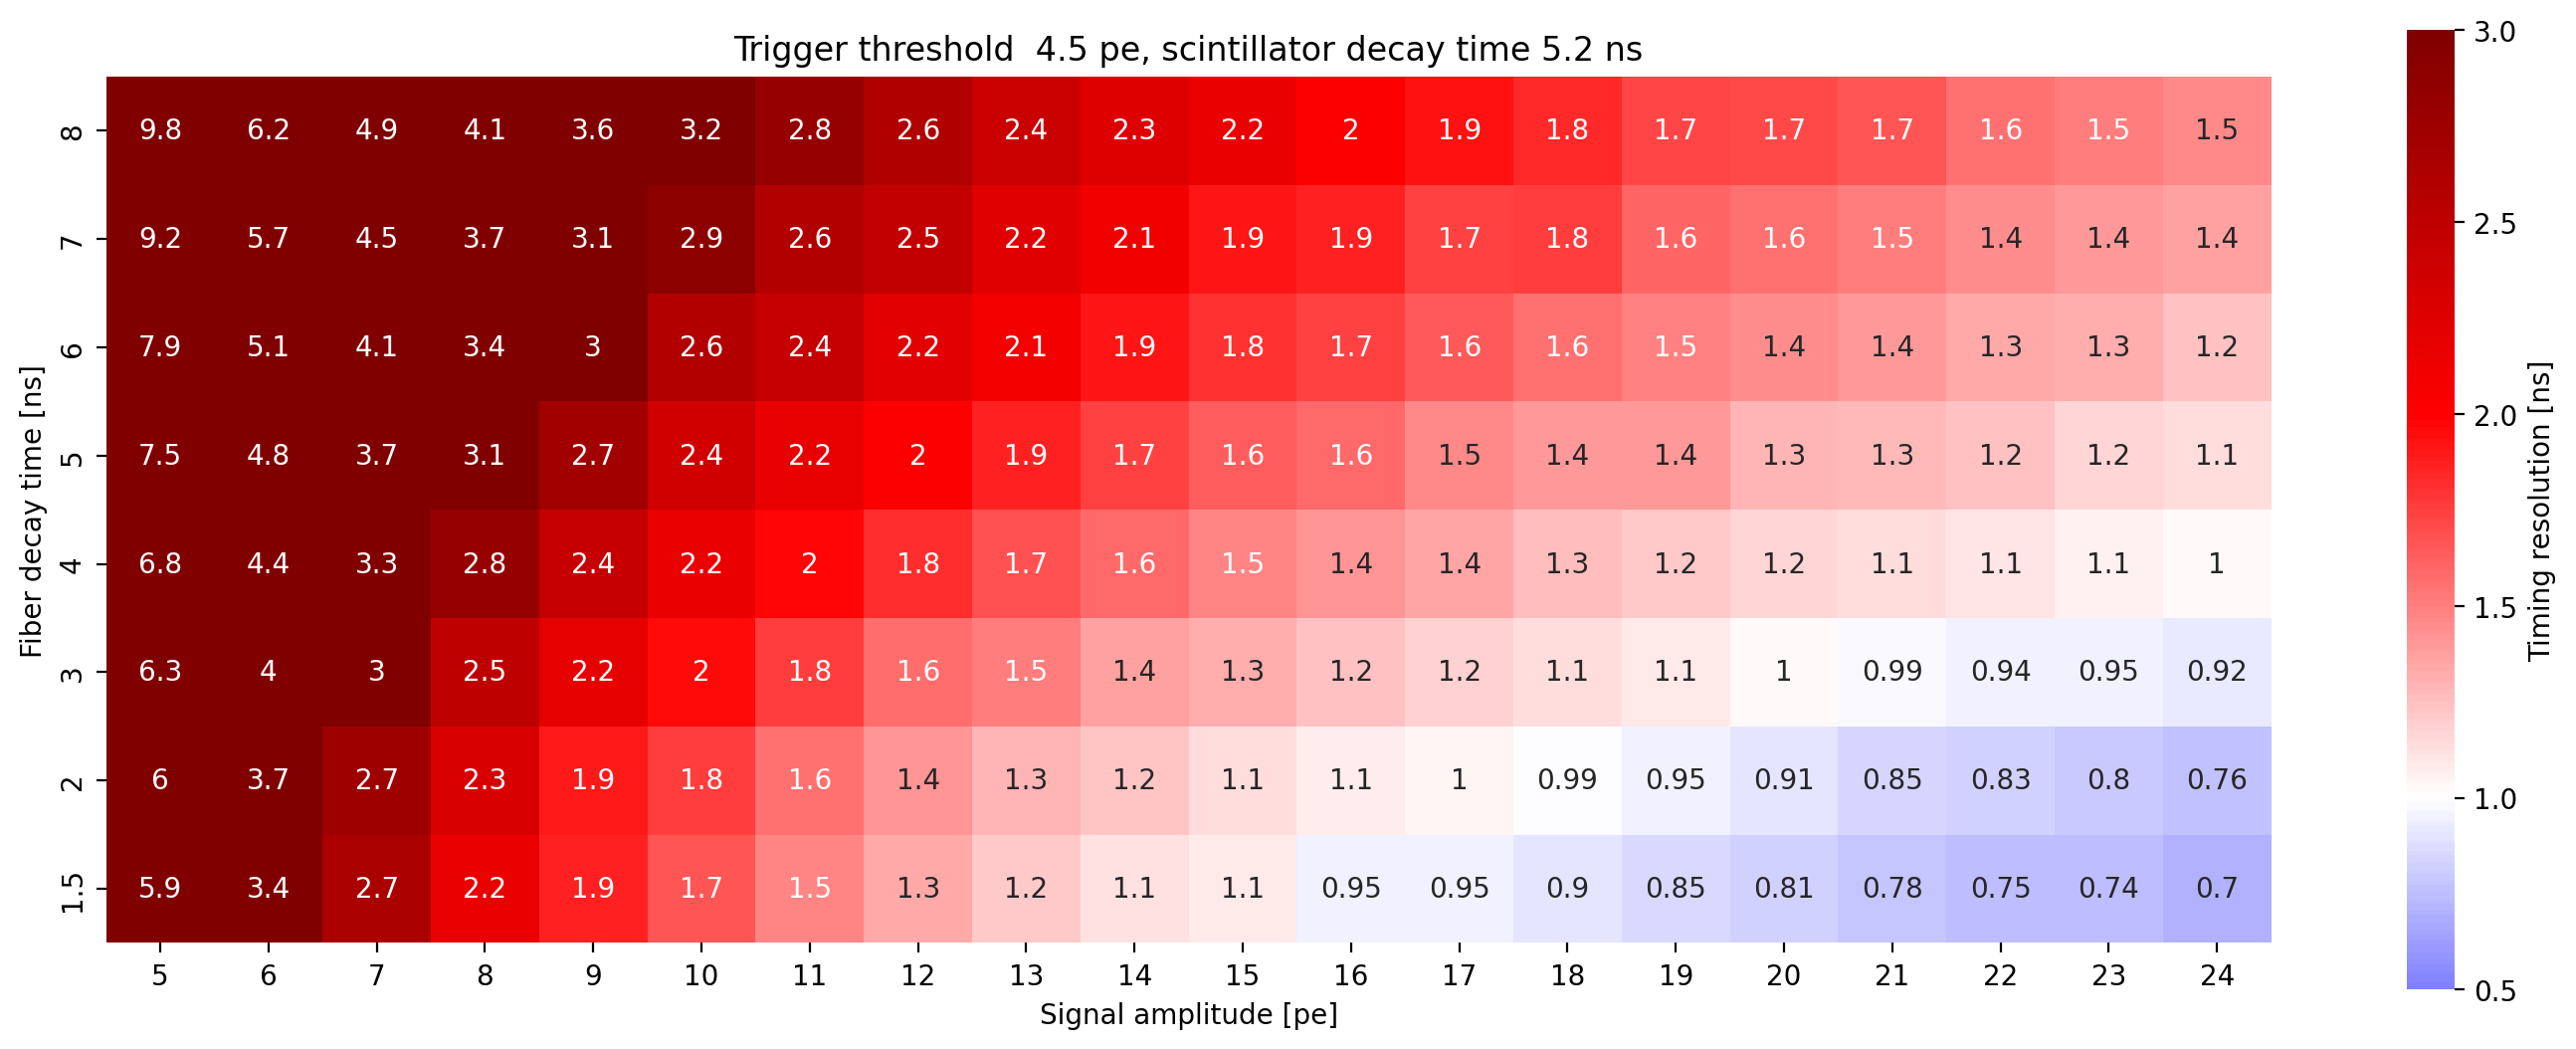

In [5]:
# Process the simulation
# Results are saved in an array with dimension of (threshold, signal_amplitude, fiber_decay_time)
results = np.zeros((len(threshold_list), len(signal_npe_list), len(t_fiber_list)))
for ipe, npe in enumerate(signal_npe_list):
    for ifiber, tfiber in enumerate(t_fiber_list):
        trigger_time = results_raw[ipe,ifiber,:,:]
        dt_widths = process_dt(trigger_time)
        results[:,ipe,ifiber] = dt_widths



for ith, th in enumerate(threshold_list):
    plt.figure(figsize = (len(signal_npe_list)/1.5+1, len(t_fiber_list)/1.5))
    ax = sns.heatmap(results[ith,:].T, 
                     center=1, vmin=0.5, vmax=3, cmap = "seismic",
                     square = True,
                     annot=True, xticklabels = signal_npe_list, yticklabels=t_fiber_list,
                     cbar_kws={'label': 'Timing resolution [ns]'})
    ax.invert_yaxis()
    
    xlabel("Signal amplitude [pe]")
    ylabel("Fiber decay time [ns]")
    title(f"Trigger threshold {th+0.5: .1f} pe, scintillator decay time {t_scint:.1f} ns")
    tight_layout()
    # savefig(f"data/FastSim_treshold_{th+0.5: .1f}_scintillator_{t_scint:.1f}_ns.jpg")

    show()


# Save data and plots
data_save = {"threshold_list": threshold_list,
             "signal_npe_list":signal_npe_list,
             "t_fiber_list":t_fiber_list,
             "results":results,
             "results_comment":"Results are saved in an array with dimension of (threshold, signal_amplitude, fiber_decay_time)"
             }
# joblib.dump(data_save, f"data/FastSim_scintillator_{t_scint:.1f}_ns.joblib")

---
dev

In [45]:
# Physics parameter
t_fiber = 2.1
t_scint = 5.2

threshold_list = [0,1,2,3]
signal_npe = 6

# Simulation setting
N_sample= 10_000

t_sample_fiber = np.random.exponential(t_fiber, (N_sample,signal_npe))
t_sample_scint = np.random.exponential(t_scint, (N_sample,signal_npe))
t_sample = np.sort(t_sample_fiber+t_sample_scint, axis=1)

trigger_time = t_sample[:,threshold_list]


Text(0.5, 1.0, '')

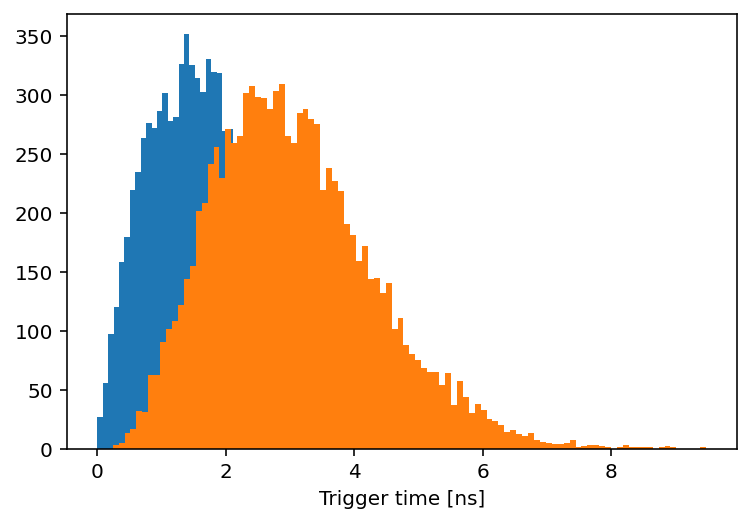

In [44]:
hist(trigger_time[:,0],bins=100);
hist(trigger_time[:,1],bins=100);
# hist(trigger_time[:,2],bins=100);
xlabel("Trigger time [ns]")
title("")

1.6836042012902392 [1.64741741 2.03184083 2.63582729]


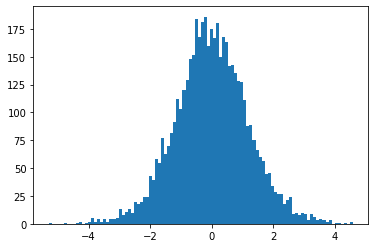

In [33]:
t = trigger_time
dt = (t[:len(t)//2]- t[len(t)//2:])/np.sqrt(2)
dt_width = np.quantile(dt, 1-0.115, axis=0)- np.quantile(dt, 0.115, axis=0)
print(std(dt[:,0]), dt_width/2.355)

hist(dt[:,0]/np.sqrt(2),bins=100);